In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

###  1.Load and prepare a dataset for binary classification.

In [2]:
# Load the dataset
data = load_breast_cancer()
X = data.data  # Features
y = data.target  # Target variable (binary classification: 0 for malignant, 1 for benign)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features to improve model performance (optional but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print dataset details
print(f"Number of features: {X.shape[1]}")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Number of features: 30
Training set size: 455
Test set size: 114


###  2.Train an SVM with linear and RBF kernel.

In [3]:
# 1. Train an SVM with a linear kernel
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)

# 2. Train an SVM with an RBF kernel
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)

#  Evaluate both models
accuracy_linear = accuracy_score(y_test, y_pred_linear)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)

print("SVM with Linear Kernel Accuracy:", accuracy_linear)
print("SVM with RBF Kernel Accuracy:", accuracy_rbf)

# You can also print a classification report for more detailed metrics
print("\nClassification Report for Linear Kernel:")
print(classification_report(y_test, y_pred_linear))
print("\nClassification Report for RBF Kernel:")
print(classification_report(y_test, y_pred_rbf))

SVM with Linear Kernel Accuracy: 0.956140350877193
SVM with RBF Kernel Accuracy: 0.9473684210526315

Classification Report for Linear Kernel:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        43
           1       0.95      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


Classification Report for RBF Kernel:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        43
           1       0.92      1.00      0.96        71

    accuracy                           0.95       114
   macro avg       0.96      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



### 3.Visualize decision boundary using 2D data.

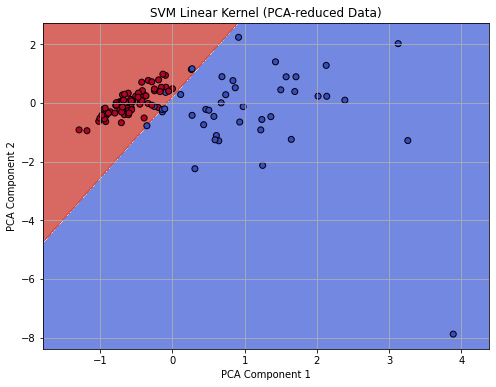

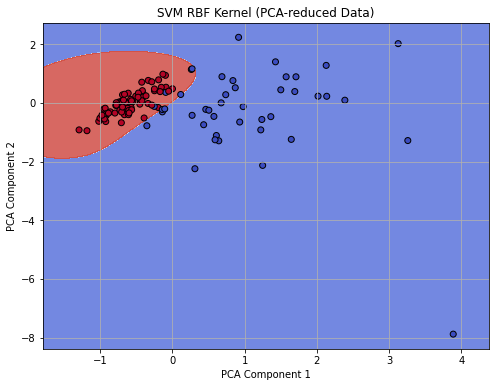

In [4]:
# Reduce features to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Standardize 2D data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train SVMs
svm_linear = SVC(kernel='linear')
svm_rbf = SVC(kernel='rbf')

svm_linear.fit(X_train_scaled, y_train)
svm_rbf.fit(X_train_scaled, y_train)

# Function to plot decision boundary
def plot_decision_boundary(model, X, y, title):
    h = 0.01
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Visualize decision boundaries
plot_decision_boundary(svm_linear, X_test_scaled, y_test, "SVM Linear Kernel (PCA-reduced Data)")
plot_decision_boundary(svm_rbf, X_test_scaled, y_test, "SVM RBF Kernel (PCA-reduced Data)")

### 4.Tune hyperparameters like C and gamma.

In [6]:
# Parameter grid for linear SVM
param_grid_linear = {
    'C': [0.01, 0.1, 1, 10, 100]
}

# Grid search for linear kernel
grid_linear = GridSearchCV(SVC(kernel='linear'), param_grid_linear, cv=5)
grid_linear.fit(X_train_scaled, y_train)

# Parameter grid for RBF SVM
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

# Grid search for RBF kernel
grid_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid_rbf, cv=5)
grid_rbf.fit(X_train_scaled, y_train)

# Best parameters and test accuracy
best_linear = grid_linear.best_estimator_
best_rbf = grid_rbf.best_estimator_

accuracy_linear = best_linear.score(X_test_scaled, y_test)
accuracy_rbf = best_rbf.score(X_test_scaled, y_test)

print("Best Linear SVM Parameters:", grid_linear.best_params_)
print(f"Linear SVM Accuracy: {accuracy_linear * 100:.2f}%\n")

print("Best RBF SVM Parameters:", grid_rbf.best_params_)
print(f"RBF SVM Accuracy: {accuracy_rbf * 100:.2f}%")

Best Linear SVM Parameters: {'C': 0.1}
Linear SVM Accuracy: 92.11%

Best RBF SVM Parameters: {'C': 100, 'gamma': 1}
RBF SVM Accuracy: 92.98%


### 5.Use cross-validation to evaluate performance.

In [7]:
# Define SVM models (use best hyperparameters if available)
svm_linear = SVC(kernel='linear', C=1)
svm_rbf = SVC(kernel='rbf', C=10, gamma=0.01)

# Perform 5-fold cross-validation on the training set
scores_linear = cross_val_score(svm_linear, X_train_scaled, y_train, cv=5)
scores_rbf = cross_val_score(svm_rbf, X_train_scaled, y_train, cv=5)

# Print mean and standard deviation of accuracies
print("Linear SVM Cross-Validation Accuracy: %.2f%% ± %.2f%%" % 
      (scores_linear.mean() * 100, scores_linear.std() * 100))

print("RBF SVM Cross-Validation Accuracy: %.2f%% ± %.2f%%" % 
      (scores_rbf.mean() * 100, scores_rbf.std() * 100))


Linear SVM Cross-Validation Accuracy: 92.09% ± 4.08%
RBF SVM Cross-Validation Accuracy: 92.31% ± 3.68%
